### pytorch MLP regressor vs sklearn MLP regressor

just comparing a MLP regressor in pytorch vs a MLP regressor in sklearn. for fun.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
from itertools import product
import root_numpy
import pandas as pd
import uproot
import torch
np.random.seed(314)

In [1]:
#variables = ['VpT','Njets','l1pT']
variables = ['VpT','Njets','j1pT', 'j2pT', 'HT','ptmiss', 'l1pT','Veta','j1eta','j2eta']
weights = ['evWeight']
#get original and target samples, madgraph:original, sherpa:target
#original  = root_numpy.root2array('/eos/user/m/mvesterb/data/madgraph/one/Nominal.root', branches=variables)
#target    = root_numpy.root2array('/eos/user/m/mvesterb/data/sherpa/one/Nominal.root', branches=variables)
##create dataframes to do the training on, and also get the sample weights in separate dataframes for resampling
#oDF   = pd.DataFrame(original,columns=variables)
#tDF   = pd.DataFrame(target,columns=variables)
original  = root_numpy.root2array('/eos/user/m/mvesterb/data/pmg/renorm2/Zmumu_Sherpa_221_testMerge/merged_sample/MUR0p5_MUF1_PDF261000.root', branches=variables)
target    = root_numpy.root2array('/eos/user/m/mvesterb/data/pmg/renorm2/Zmumu_Sherpa_221_testMerge/merged_sample/MUR2_MUF1_PDF261000.root', branches=variables)
originalW = root_numpy.root2array('/eos/user/m/mvesterb/data/pmg/renorm2/Zmumu_Sherpa_221_testMerge/merged_sample/MUR0p5_MUF1_PDF261000.root', branches=weights)
targetW   = root_numpy.root2array('/eos/user/m/mvesterb/data/pmg/renorm2/Zmumu_Sherpa_221_testMerge/merged_sample/MUR2_MUF1_PDF261000.root', branches=weights)
#create dataframes to do the training on
oDF  = pd.DataFrame(original,columns=variables)
tDF  = pd.DataFrame(target,columns=variables)
oWDF  = pd.DataFrame(originalW,columns=weights)
tWDF  = pd.DataFrame(targetW,columns=weights)

NameError: name 'root_numpy' is not defined

In [ ]:
pTruthMUR1    = (oWDF.evWeight)/np.sum(oWDF.evWeight.astype(np.float))
pTruthMUR2    = (tWDF.evWeight)/np.sum(tWDF.evWeight.astype(np.float))
#iTruthMUR1    = np.random.choice(np.arange(len(dfMUR1)),size=int(np.sum(dfWMUR1.truthWeight.astype(np.float))),p=pTruthMUR1)
iTruthMUR1    = np.random.choice(np.arange(len(oDF)),size=len(oDF),p=pTruthMUR1)
iTruthMUR2    = np.random.choice(np.arange(len(tDF)),size=len(tDF),p=pTruthMUR2)
o     = oDF.iloc[iTruthMUR1] #original
t     = tDF.iloc[iTruthMUR2] #target

A discriminator is trained to differentiate the original and the target distributions from each other, as well as differentiating the target distribution from the original distributions with the learned carl applied. Well learned weights would make the target and reweighted distributions very similar and indistinguishable for the discriminator. 

this is the sklearn implementation:

In [ ]:
n_target = o.shape[0]
X0_all = o.values[:n_target,:]
X0_test = o.values[-n_target:,:]
X1_all = t.values
#make training data from all samples
num1 = X0_all.shape[0]
num2 = X1_all.shape[0]
X = np.vstack((X0_all,X1_all))
y = np.ones(num1 + num2, dtype=np.int)
X0, X1 = X0_all, X1_all
y[num1:] = 0
print(X0.shape)
print(X1.shape)
print(y.shape)
print(X.shape)

In [2]:
from sklearn.neural_network import MLPRegressor 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
classifier = MLPRegressor(tol=1e-05, activation="logistic", 
               hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
               learning_rate="constant", solver="lbfgs", random_state=1,
               max_iter=100)
classifier.fit(X,y) 
y_train = classifier.predict(X)
#print("accuracy_score", accuracy_score(y, y_train))
print("classifier", classifier)
print("classifier score",classifier.score(X,y))

NameError: name 'X' is not defined

In [18]:
y_pred = classifier.predict(X0_test)
print("y",y)
print("y_pred",y_pred)
print("classifier.score(X,y)",classifier.score(y_pred,y))

('y', tensor([1., 1., 1.,  ..., 0., 0., 0.]))
('y_pred', array([0.47940063, 0.47957589, 0.47939171, ..., 0.54771504, 0.47939027,
       0.47938647]))


ValueError: Expected 2D array, got 1D array instead:
array=[0.47940063 0.47957589 0.47939171 ... 0.54771504 0.47939027 0.47938647].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

This is the torch equivalence:

In [12]:
oT = torch.tensor(oDF[variables].values,dtype=torch.float)
tT = torch.tensor(tDF[variables].values,dtype=torch.float)

X0_all  = oT[:n_target,:]
X0_test = oT[-n_target:,:]
X1_all = tT

num1 = X0_all.shape[0]
num2 = X1_all.shape[0]
X = torch.cat([X0_all,X1_all])
y = torch.ones(num1+num2,dtype=torch.float) 
y[num1:] = 0
print("y",y)
X0, X1 = X0_all, X1_all

X0.requires_grad_(True),X1.requires_grad_(True),X.requires_grad_(True)

X = torch.FloatTensor(X)
X0 = torch.FloatTensor(X0)
X1 = torch.FloatTensor(X1)
y = torch.FloatTensor(y)
print("y",y)

print(X0.shape)
print(X1.shape)
print(y.shape)
print(X.shape)

('y', tensor([1., 1., 1.,  ..., 0., 0., 0.]))
('y', tensor([1., 1., 1.,  ..., 0., 0., 0.]))
torch.Size([234792, 10])
torch.Size([235163, 10])
torch.Size([469955])
torch.Size([469955, 10])


In [13]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils_data
from torch.autograd import Variable


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = t.sigmoid(self.fc1(x))
        x = t.sigmoid(self.fc2(x))
        x = t.sigmoid(self.fc3(x))
        return x


In [14]:
inputs = Variable(torch.Tensor(X))
targets = Variable(torch.Tensor(y))
print("y",y)
losses = []
num_epoch = 5
print("inputs.size()[1]",inputs.size()[1])
model = MLP(input_size = inputs.size()[1], hidden_size = 10, output_size = 1)
print("inputs",inputs)
print("targets",targets)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-7, weight_decay=1e-4)

loss_fct = nn.BCELoss()
training_samples = utils_data.TensorDataset(inputs, targets)
data_loader_trn = utils_data.DataLoader(training_samples, batch_size=200, drop_last=False, shuffle=True)

#train
for epoch in range(num_epoch):
    cum_loss = 0
    print("doing epoch ",epoch)
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        tr_x, tr_y = data.float(), target.float()
        
        pred = model(tr_x) 
        #print("pred",pred)
        #print("tr_y.unsqueeze(1)",tr_y.unsqueeze(1))
        loss = loss_fct(pred, tr_y.unsqueeze(1)) 
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        losses.append(loss)

            
    #if epoch % 10 == 0:
    print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, cum_loss))

final_prediction = model(inputs)
final_pred_np = final_prediction.clone().detach().numpy()

np.corrcoef(final_pred_np.squeeze(), targets)[0,1]


('y', tensor([1., 1., 1.,  ..., 0., 0., 0.]))
('inputs.size()[1]', 10)
('inputs', tensor([[ 1.1450e+02,  3.0000e+00,  8.8449e+01,  ...,  1.8224e-01,
         -4.4660e-02,  2.0089e+00],
        [ 3.1602e+01,  1.0000e+00,  2.6546e+01,  ...,  1.5461e+00,
         -1.8486e+00,  0.0000e+00],
        [ 7.3951e+01,  1.0000e+00,  3.7338e+01,  ...,  1.7023e+00,
          1.3926e+00,  0.0000e+00],
        ...,
        [ 1.6740e+01,  0.0000e+00,  0.0000e+00,  ..., -3.4089e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.8647e+01,  1.0000e+00,  5.4992e+01,  ..., -1.0928e+00,
          1.8139e-01,  0.0000e+00],
        [ 1.0084e+01,  0.0000e+00,  0.0000e+00,  ...,  3.0263e+00,
          0.0000e+00,  0.0000e+00]]))
('targets', tensor([1., 1., 1.,  ..., 0., 0., 0.]))
('doing epoch ', 0)
Epoch [1/5], Loss: 1643.2527
('doing epoch ', 1)
Epoch [2/5], Loss: 1643.0412
('doing epoch ', 2)
Epoch [3/5], Loss: 1642.8326
('doing epoch ', 3)
Epoch [4/5], Loss: 1642.6231
('doing epoch ', 4)
Epoch [5/5], Loss

0.00012159664291087596

In [15]:
final_prediction = model(X0)
print("final_prediction0",final_prediction)

('final_prediction0', tensor([[0.5506],
        [0.5563],
        [0.5549],
        ...,
        [0.5503],
        [0.5503],
        [0.5566]], grad_fn=<SigmoidBackward>))


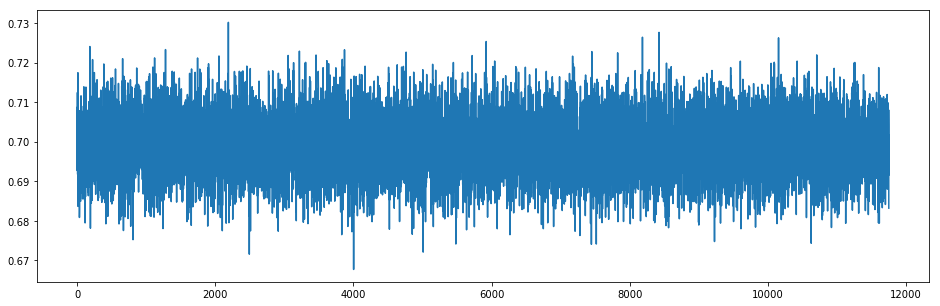

In [16]:
plt.figure(figsize=(16,5))
#plt.ylim(0,max(losses)+0.02)
plt.plot(losses)
